In [1]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
import sympy as smp
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial

In [2]:
def phi_0(k: np.array) -> float:
    k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
    # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
    # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val



def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
    test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    

### Standard values

In [3]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_400 = w_800 * 800 / 400
w_s = w_400

A_0_s = F_0 / w_400

E_0_s = -13.6 / conversion_ev_au

N_s = 3
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 0.5

In [4]:
k_test = np.array([1, 1, 0])

res = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

In [5]:
res.real, res.imag, res

(-1.299044079014644e-07,
 -6.152672081675835e-07,
 (-1.299044079014644e-07-6.152672081675835e-07j))

In [6]:
res.real, res.imag, res

(-1.299044079014644e-07,
 -6.152672081675835e-07,
 (-1.299044079014644e-07-6.152672081675835e-07j))

In [7]:
dp_dk(res)

3.954288926385625e-13

In [8]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]

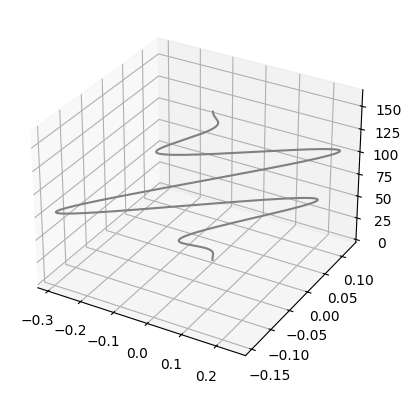

In [9]:
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [40]:
import numpy as np
from pathos.multiprocessing import ProcessingPool
from functools import partial

def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    import numpy as np
    from scipy.integrate import quad 
    
    def phi_0(k: np.array) -> float:
        k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
        # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
        # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
        solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
        return solution

    def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
                 A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
                 #sin4cos2, sin4sin2, sin2cos, sin2sin
                ) -> float:
        """
        sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
        """

        i = complex(0, 1)

        k_squared = k[0]**2 + k[1]**2 + k[2]**2

        # I need to make for kx and ky

        test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
        test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
        test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
        test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)

        # kx here first k[0]
        if k[0] != 0:
            i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
                (-1) * i * E_0 * ts +
                     # k^2
                i * (k_squared * ts + 
                     # k*A
                     # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                     #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                     #                                ) + 
                     A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                                  full_output=False)[0] +
                                                      k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                            full_output=False)[0]
                                                     ) + 
                     # A ** 2
                     # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                     #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                     #                            )
                     A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                                  epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                    full_output=False)[0]
                                                 )
                    )
            )
            sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
        else:
            sol_large_x = [0, 0]

        # ky here first k[1]
        if k[1] != 0:
            i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
                (-1) * i * E_0 * ts +
                     # k^2
                i * (k_squared * ts + 
                     # k*A
                     # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                     #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                     #                                ) + 
                     A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                                  full_output=False)[0] +
                                                      k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                            full_output=False)[0]
                                                     ) + 
                     # A ** 2
                     # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                     #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                     #                            )
                     A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                                  epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                    full_output=False)[0]
                                                 )
                    )
            )
            sol_large_y = quad(i_y, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
        else:
            sol_large_y = [0, 0]


        full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])

        M = (-1) * i * phi_0(k) * full_integral

        return M
    
    def dp_dk(M: complex) -> float:
        return M.real**2 + M.imag**2
    
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]

length = 81
start_val = -4
end_val = 4
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)


In [33]:
kx_plot

array([-4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. , -4. ,
       -3.2, -3.2, -3.2, -3.2, -3.2, -3.2, -3.2, -3.2, -3.2, -3.2, -3.2,
       -2.4, -2.4, -2.4, -2.4, -2.4, -2.4, -2.4, -2.4, -2.4, -2.4, -2.4,
       -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6,
       -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,
        1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,
        2.4,  2.4,  2.4,  2.4,  2.4,  2.4,  2.4,  2.4,  2.4,  2.4,  2.4,
        3.2,  3.2,  3.2,  3.2,  3.2,  3.2,  3.2,  3.2,  3.2,  3.2,  3.2,
        4. ,  4. ,  4. ,  4. ,  4. ,  4. ,  4. ,  4. ,  4. ,  4. ,  4. ])

In [41]:
max(values_plot)

139.4167881840998

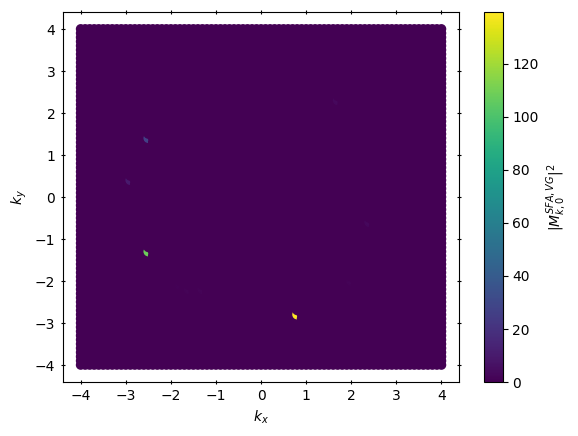

In [42]:
# Lav et farvekodet plot
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot)

# Vend akserne (det er et Kiel diagram), sæt ticks korrekt og titler på
ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

# Indsæt colorbar så man kan se hvad der foregår
fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')


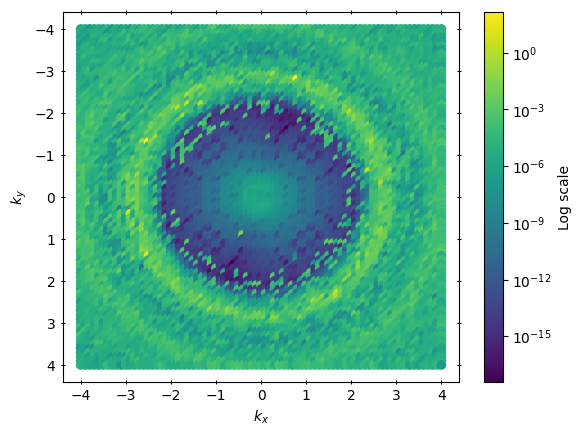

In [43]:
from matplotlib.colors import LogNorm

# Assuming you already have kx_plot, ky_plot, and values_plot defined

# Create a scatter plot with logarithmic color scale
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, norm=LogNorm())

# Reverse the y-axis to match a Kiel diagram
ax.invert_yaxis()

# Set labels and ticks
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
ax.tick_params(direction="inout", right=True, top=True)

# Add colorbar with logarithmic scale
cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
cbar.ax.set_ylabel('Log scale')

plt.show()


In [ ]:
A_0_s

In [46]:
import pandas as pd

In [48]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot

In [50]:
df.to_pickle("0002_windows.pkl")